<a href="https://colab.research.google.com/github/raghavlaad-89/Ksolve-AIML/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import zipfile
import os

# Define the path to the zip file and the directory to extract to
zip_path = '/content/drive/MyDrive/Colab Notebooks/Problem Statement 2/dataset.zip'
extract_dir = '/content/dataset/dataset'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [12]:
# Import necessary libraries
import pandas as pd
import json
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from textblob import TextBlob
from transformers import pipeline, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

# Load large JSON files in chunks
def load_json_in_chunks(file_path, chunk_size=10000):
    chunks = []
    for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

def load_sample(file_path, nrows=100):
    return pd.read_json(file_path, lines=True, nrows=nrows)

business_df = load_sample('/content/dataset/dataset/yelp_academic_dataset_business.json')
checkin_df = load_sample('/content/dataset/dataset/yelp_academic_dataset_checkin.json')
review_df = load_sample('/content/dataset/dataset/yelp_academic_dataset_review.json')
tip_df = load_sample('/content/dataset/dataset/yelp_academic_dataset_tip.json')
user_df = load_sample('/content/dataset/dataset/yelp_academic_dataset_user.json')


In [13]:
review_df.tail()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
95,QS7CuOtFLuS3dnwKHRtSYQ,PBnEwGVCBL0N-bET6ZI6kQ,m5-FtgWRd4qA7j0vaOXiXQ,5,0,0,0,Had to wait until my third trip to NOLA to act...,2016-11-10 20:56:13
96,4PHFo_GRG4FEk1q4X7xQVQ,jbsCBG0A-3wVDjrKar-0Wg,X63jIMRHYBvKKQDuJTRiQQ,5,2,0,1,A GREAT EXPERIENCE!!!!!!!!! I was a completel...,2014-10-11 13:55:05
97,1c6sgLe07HAhipebsQ1wgA,ZRXvbrutBBULaFS6T9NCwA,HnhxO2cpa15AHI1456Pl6Q,5,0,1,0,Wow! I never thought my sons phone could be re...,2015-10-17 00:55:35
98,PPgbLBvi34A6m7bKJfTwhw,3TL6HZ1JrKcNTvGDWKlrow,GyC36Pn0Q1-qHnqXys6yFg,1,0,0,0,Service and management terrible... After messi...,2013-12-07 13:17:13
99,gImS1dtA_TixEouDfp2o4g,xE7AXFF9wVaN6id6OCtH3Q,D5V0Fawd6ODVgqCY8xngsw,4,1,0,2,I have been to a number of dog friendly hotels...,2017-01-14 21:05:04


In [14]:
# Check a sample of the text column
sample_texts = df['text'].head(10)
print(sample_texts)


0    if you decide to eat here, just be aware it is...
1    i've taken a lot of spin classes over the year...
2    family diner. had the buffet. eclectic assortm...
3    wow!  yummy, different,  delicious.   our favo...
4    cute interior and owner (?) gave us tour of up...
5    i am a long term frequent customer of this est...
6    loved this tour! i grabbed a groupon and the p...
7    amazingly amazing wings and homemade bleu chee...
8    this easter instead of going to lopez lake we ...
9    had a party of 6 here for hibachi. our waitres...
Name: text, dtype: object


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Error processing text: if you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. we... Exception: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing text: i've taken a lot of spin classes over the years, and nothing compares to the classes at body cycle. ... Exception: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing text: family diner. had the buffet. eclectic assortment: a large chicken leg, fried jalapeño, tamale, two ... Exception: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing text: wow!  yummy, different,  delicious.   our favorite is the lamb curry and korma.  with 10 dif

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


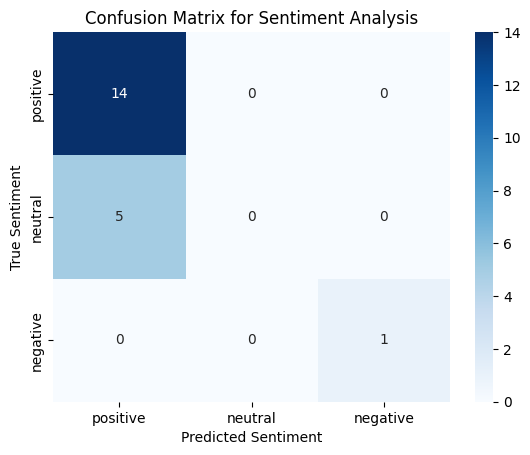

In [16]:


# Data Preprocessing
def preprocess_data(review_df, business_df):
    # Merging the review and business datasets
    df = review_df.merge(business_df[['business_id', 'name', 'categories']], on='business_id', how='left')
    df['text'] = df['text'].apply(lambda x: x.lower())  # Convert reviews to lowercase
    return df[['business_id', 'name', 'categories', 'stars', 'text']]

df = preprocess_data(review_df, business_df)

# Load Spacy model for Aspect Extraction
nlp = spacy.load("en_core_web_sm")

# Aspect keywords mapping to predefined aspects
aspect_keywords = {
    'Food Quality': ['food', 'quality', 'taste', 'flavor', 'dish'],
    'Service': ['service', 'staff', 'waiter', 'waitress', 'customer service'],
    'Ambiance': ['ambiance', 'atmosphere', 'environment', 'decor'],
    'Pricing': ['price', 'cost', 'value', 'expensive', 'cheap'],
    'Cleanliness': ['cleanliness', 'clean', 'dirty', 'hygiene']
}

# Aspect Extraction using keyword-based approach
def extract_aspects(review):
    doc = nlp(review)
    aspects = []
    for aspect in aspect_keywords:
        if any(keyword in review for keyword in aspect_keywords[aspect]):
            aspects.append(aspect)
    return aspects

df['aspects'] = df['text'].apply(extract_aspects)

# Sentiment Analysis using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['text'].apply(get_sentiment)

# Load BERT sentiment analysis model and tokenizer
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# BERT Sentiment Analysis
def bert_sentiment_analysis(text):
    if isinstance(text, str) and text.strip():  # Ensure text is a non-empty string
        try:
            # Tokenize and truncate the text to 512 tokens
            inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")

            # Perform sentiment analysis on the truncated text
            sentiment = classifier(inputs['input_ids'])[0]
            return sentiment['label'].lower()
        except Exception as e:
            print(f"Error processing text: {text[:100]}... Exception: {e}")
            return 'unknown'
    else:
        print(f"Invalid text input: {text}")
        return 'unknown'

df['bert_sentiment'] = df['text'].apply(bert_sentiment_analysis)

# Splitting dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Evaluation Metrics for Aspect Extraction
def calculate_aspect_metrics(true_aspects, predicted_aspects):
    # Flatten lists for comparison
    true_aspects_flat = [aspect for sublist in true_aspects for aspect in sublist]
    pred_aspects_flat = [aspect for sublist in predicted_aspects for aspect in sublist]

    precision = len(set(true_aspects_flat) & set(pred_aspects_flat)) / len(set(pred_aspects_flat)) if len(set(pred_aspects_flat)) > 0 else 0
    recall = len(set(true_aspects_flat) & set(pred_aspects_flat)) / len(set(true_aspects_flat)) if len(set(true_aspects_flat)) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# Dummy labeled data (You would use real labeled data here)
true_aspects = [['food', 'service'], ['location', 'ambiance'], ['staff', 'cleanliness']]  # Example true aspects
pred_aspects = df['aspects'].tolist()[:3]  # Extracted aspects (first 3 as an example)

precision, recall, f1 = calculate_aspect_metrics(true_aspects[0], pred_aspects)
print(f"Aspect Extraction - Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Evaluation for Sentiment Classification (Using TextBlob)
y_true = test_df['stars'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')
y_pred = test_df['sentiment']

accuracy = accuracy_score(y_true, y_pred)
precision_sentiment = precision_score(y_true, y_pred, average='weighted', labels=['positive', 'neutral', 'negative'])
recall_sentiment = recall_score(y_true, y_pred, average='weighted', labels=['positive', 'neutral', 'negative'])
f1_sentiment = f1_score(y_true, y_pred, average='weighted', labels=['positive', 'neutral', 'negative'])

print(f"Sentiment Classification - Accuracy: {accuracy:.2f}, Precision: {precision_sentiment:.2f}, Recall: {recall_sentiment:.2f}, F1 Score: {f1_sentiment:.2f}")

# Confusion Matrix for Sentiment Classification
conf_matrix = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.title('Confusion Matrix for Sentiment Analysis')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.show()

# Evaluation for BERT Sentiment Analysis
bert_y_pred = test_df['bert_sentiment']
bert_accuracy = accuracy_score(y_true, bert_y_pred)
bert_f1_sentiment = f1_score(y_true, bert_y_pred, average='weighted', labels=['positive', 'neutral', 'negative'])

# print(f"BERT Sentiment Classification - Accuracy: {bert_accuracy:.2f}, F1 Score: {bert_f1_sentiment:.2f}")